In [113]:
# For data loading and scientific computing
import pandas as pd
import numpy as np
import random
import os

# For data visualization
import matplotlib.pyplot as plt
import plotly.express as px

# Deep learning framework
import torch
import torch.nn as nn

# data processing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score 

## Configuration

In [114]:
class config:
    
    batch_size = 128
    lr = 1e-3
    epochs = 100
    weight_decay = 1e-2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42

## Utils

In [115]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## EDA

從下面的 dataframe 可以看出，第一個 column 表示每個樣本的類別，剩餘 256 個 columns 表示影像的灰階 pixel values

In [116]:
# Read in the dataframe
train_data = pd.read_csv('data/zip.train1.csv', header=None)
test_data = pd.read_csv('data/zip.test1.csv', header=None)
train_data

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,6,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.631,0.862,...,0.304,0.823,1.000,0.482,-0.474,-0.991,-1.000,-1.000,-1.000,-1.0
1,5,-1.0,-1.0,-1.0,-0.813,-0.671,-0.809,-0.887,-0.671,-0.853,...,-0.671,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1.0
2,4,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-0.109,1.000,-0.179,-1.000,-1.000,-1.000,-1.0
3,7,-1.0,-1.0,-1.0,-1.000,-1.000,-0.273,0.684,0.960,0.450,...,-0.318,1.000,0.536,-0.987,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
4,3,-1.0,-1.0,-1.0,-1.000,-1.000,-0.928,-0.204,0.751,0.466,...,0.466,0.639,1.000,1.000,0.791,0.439,-0.199,-0.883,-1.000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7286,3,-1.0,-1.0,-1.0,-0.988,-0.527,-0.208,0.620,1.000,0.467,...,-0.116,0.899,0.416,-0.510,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
7287,3,-1.0,-1.0,-1.0,-0.990,0.708,0.557,0.347,-0.107,-0.758,...,0.697,0.636,0.167,-0.968,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
7288,3,-1.0,-1.0,-1.0,-0.783,-0.984,-0.827,0.068,1.000,1.000,...,0.805,1.000,1.000,0.727,-0.342,-0.933,-1.000,-1.000,-1.000,-1.0
7289,0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.549,0.463,0.999,0.999,...,-0.231,0.621,0.999,-0.042,-0.231,-0.687,-1.000,-1.000,-1.000,-1.0


In [117]:
train_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
count,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,...,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000
mean,3.903443,-0.996417,-0.981138,-0.951153,-0.887738,-0.773468,-0.610302,-0.368991,-0.045769,-0.052641,...,-0.198547,0.139823,0.116439,-0.314108,-0.653711,-0.837858,-0.922194,-0.957393,-0.979290,-0.994678
std,2.996386,0.051713,0.151202,0.244264,0.360516,0.502659,0.628710,0.716032,0.768304,0.752979,...,0.772895,0.752984,0.757336,0.725859,0.582555,0.414646,0.300830,0.228700,0.158998,0.066056
min,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.999000,-0.950000,...,-1.000000,-0.661500,-0.738000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,4.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.719000,0.061000,0.002000,...,-0.353000,0.368000,0.336000,-0.579000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,7.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.962000,-0.391000,0.254500,0.696000,0.674500,...,0.554000,0.835000,0.815000,0.346000,-0.504500,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
max,9.000000,0.638000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.592000


In [118]:
print(f"Number of training samples: {train_data.shape[0]}")
print(f"Number of testing samples: {test_data.shape[0]}")

Number of training samples: 7291
Number of testing samples: 2007


## Show the number of images in each digit

In [119]:
train_data.iloc[:, 0].value_counts().sort_index()

0
0    1194
1    1005
2     731
3     658
4     652
5     556
6     664
7     645
8     542
9     644
Name: count, dtype: int64

## Plot each digit for ten pictures

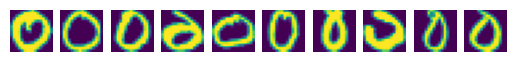

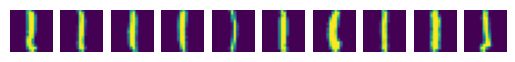

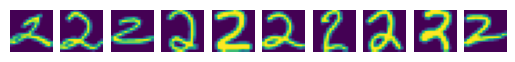

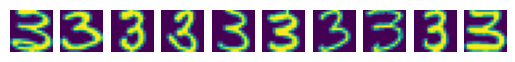

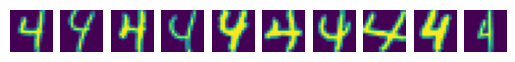

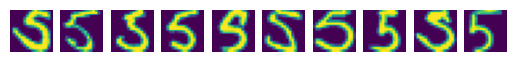

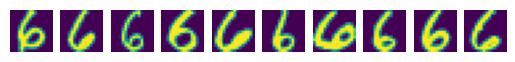

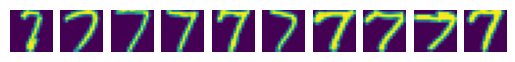

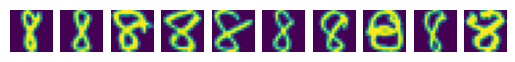

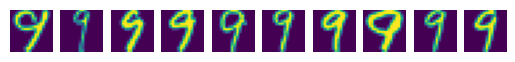

In [120]:
for i in range(10):
    fig = plt.figure()
    digit_sample_data = train_data[train_data.iloc[:,0] == i].sample(10, random_state=1)
    for i in range(len(digit_sample_data)):
        image = np.array(digit_sample_data.iloc[i, 1:]).reshape(16, 16)
        plt.subplot(1,10,i+1)
        plt.imshow(image,vmin=-1,vmax=1)
        plt.axis('off')
        plt.subplots_adjust(wspace=None, hspace=None)

In [121]:
train_label_distribution = train_data.iloc[:, 0].value_counts().sort_index()
train_label_distribution = pd.DataFrame(
    {
        "labels": train_label_distribution.index.astype(str),
        "number_of_samples": train_label_distribution.values
    }
)

fig = px.bar(
    train_label_distribution, x="labels", y="number_of_samples",
    labels=dict(y="number of samples"),
)
fig.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False),  # Show x-axis grid
    yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False),  # Show y-axis grid
    title=dict(text="Number of Samples Per Labels", x=0.5, y=0.975, font=dict(size=20))
)
fig.show()

## 建立pytorch 資料集的 class

In [122]:
class HandwrittenDigits(torch.utils.data.Dataset):
    
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        
    def __getitem__(self, x):
        image, label = self.df.iloc[x, 1:].to_numpy(), self.df.iloc[x, 0]
        image, label = torch.tensor(image), torch.tensor(label)
        return image, label
        
    def __len__(self):
        return self.df.shape[0]

In [123]:
def split_ids(n, train_size, val_size):
    train_size = int(train_size * n)
    val_size = int(val_size * n)
#     test_size = int(test_size * n)

    train_indices, val_indices = train_test_split(
        np.linspace(0, n - 1, n).astype("int"),
        test_size=val_size,
        random_state=42,
    )

    return train_indices, val_indices

### 將training data 以 8:2 的比例分成 training data 與 valid data 並建立data loader

In [124]:
dataset = HandwrittenDigits(train_data)
train_ids, val_ids = split_ids(train_data.shape[0], 0.8, 0.2)
train_dataset = torch.utils.data.Subset(dataset, train_ids)
val_dataset = torch.utils.data.Subset(dataset, val_ids)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

Image shape: torch.Size([16, 256]), label shape torch.Size([])


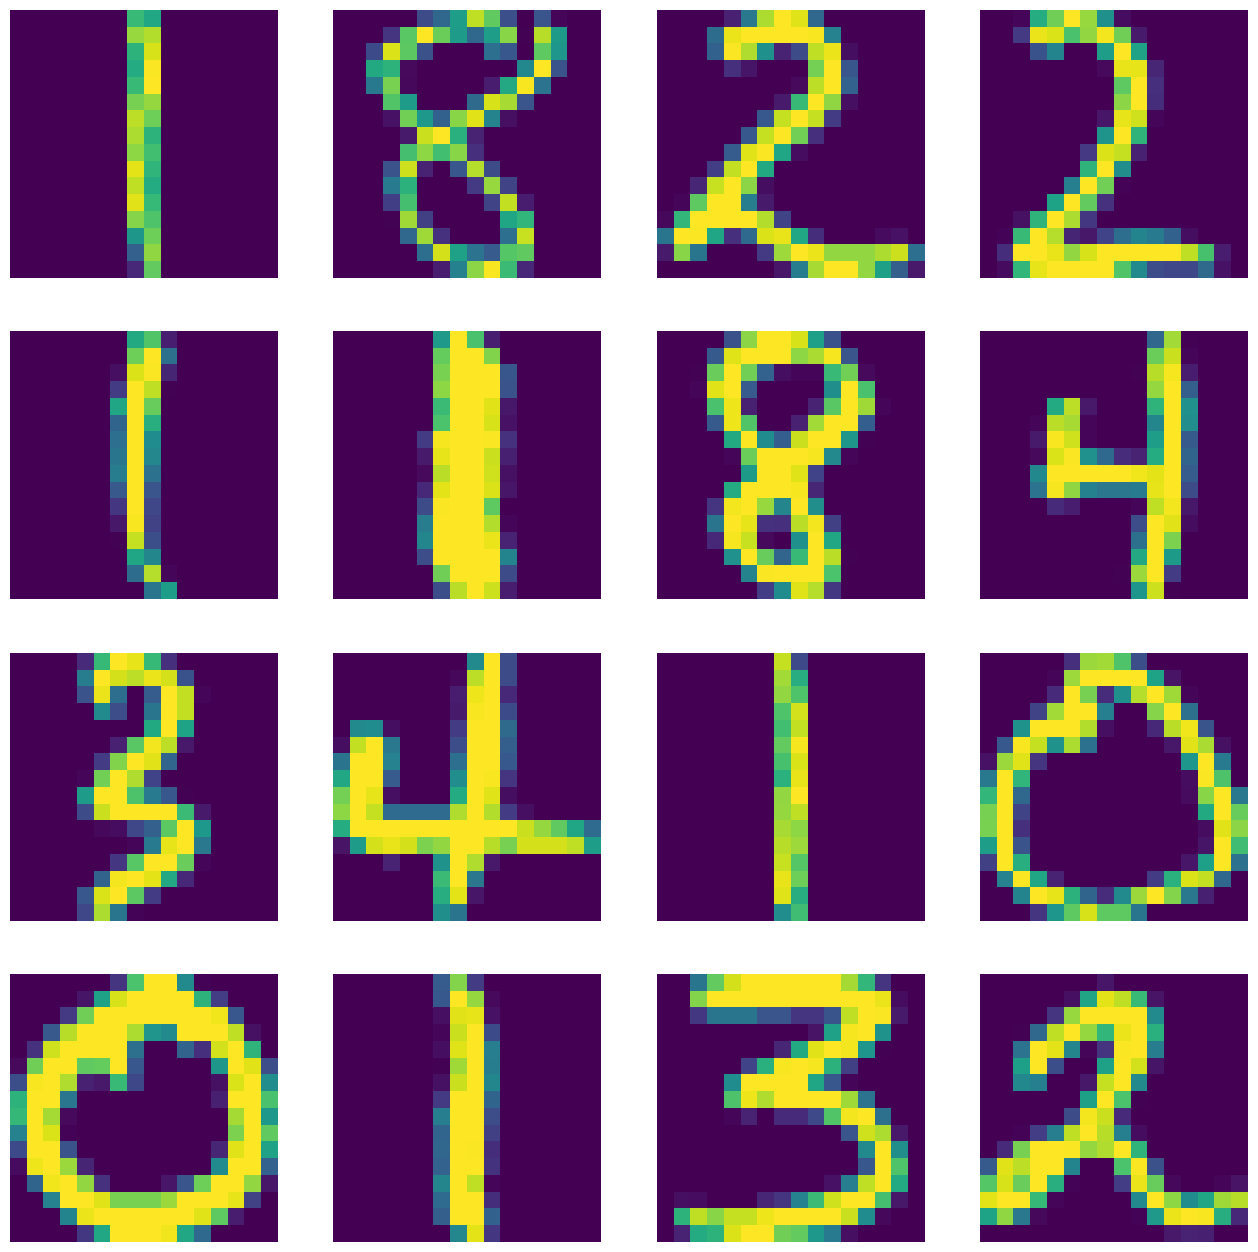

In [125]:
images, labels = next(iter(train_loader))
images, labels = images[:16], labels[:16]

plt.figure(figsize=(16,16))

for i, (image ,label) in enumerate(zip(images, labels)):
    image = image.numpy().reshape(16, 16)
        
    plt.subplot(4,4,i+1)
    plt.imshow(image,vmin=-1,vmax=1)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
        
print(f"Image shape: {images.shape}, label shape {label.shape}")
    
del images, labels

## 定義 neural network 的架構，net1 -> one hidden layer

In [126]:
class SimpleNN1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN1, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

在上述的程式碼中，`nn.Linear(input_dim, output_dim)` 對應到一個線性變換，換句話說

$$fc(X)=X_{n*i}W_{i*o} + B_{o}$$

- $n:$ 樣本個數
- $i:$ 輸入通道
- $o:$ 輸出通道

總體需要訓練的參數為 $i*o+o$

# Training

In [127]:
def evaluator(preds, gts):
    
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
    
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average="macro")
    
    return acc, f1

def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    train_loss = .0
    predictions, ground_truths = [], []
    for images, labels in train_loader:
        images = images.to(device=device, dtype=torch.float)
        labels = labels.to(device=device, dtype=torch.long)
        
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        
        predictions.append(preds)
        ground_truths.append(labels)
        
    train_loss /= len(train_loader)
    
    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1 = evaluator(predictions, ground_truths)
    
    return train_loss, 100*train_acc, 100*train_f1
        
def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device=device, dtype=torch.float)
            labels = labels.to(device=device, dtype=torch.long)

            logits = model(images)
            loss = criterion(logits, labels)
            
            valid_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
        
            predictions.append(preds)
            ground_truths.append(labels)
        
    valid_loss /= len(valid_loader)
    
    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    valid_acc, valid_f1 = evaluator(predictions, ground_truths)
    return valid_loss, 100*valid_acc, 100*valid_f1

def testing(model, checkpoint_name, output_name):
    best_ckpt = torch.load(f"model/{checkpoint_name}", map_location=config.device)
    model.load_state_dict(best_ckpt["model"])
    model.eval()
    model.cpu()
    test_data = pd.read_csv("data/zip.test1.csv", header=None)
    test_data = torch.tensor(np.array(test_data), dtype=torch.float)
    logits = model(test_data)
    predict = torch.argmax(logits, dim=1)
    output = pd.DataFrame(logits.detach().numpy())
    output['predicted'] = predict.detach().numpy()
    output.to_csv(f"output/{output_name}")
    

In [128]:
def get_plot(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()

    misclassfication_rate = [100 - i for i in history["valid"]["acc"][10:31]]
    min_index = np.argmin(misclassfication_rate)
    min_rate = misclassfication_rate[min_index]
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(10,31), misclassfication_rate, label='Valid accuracy')
    plt.scatter([min_index+10], [min_rate], s=20, c='r', label='min rate')
    # plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('misclassfication_rate')
    plt.legend()
    plt.title('Validation Accuracy Curves from 10 to 30 epochs')
    plt.show()

In [129]:
def main(model, checkpoint_name, output_name):
    print(model)
    seed_everything(config.seed)
    
    dataset = HandwrittenDigits(train_data)
    train_ids, val_ids = split_ids(train_data.shape[0], 0.8, 0.2)
    
    train_dataset = torch.utils.data.Subset(dataset, train_ids)
    val_dataset = torch.utils.data.Subset(dataset, val_ids)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers = 8)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers = 8)
    
    criterion = nn.CrossEntropyLoss()
    device = config.device
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        epochs=config.epochs, 
        steps_per_epoch=train_loader.__len__(),
        max_lr=config.lr,
    )
    
    best_val_loss = float("inf")
    history = {
        "train": {
            "loss": [],
            "acc": [],
            "f1": []
        },
        "valid": {
            "loss": [],
            "acc": [],
            "f1": []
        },
    }
    
    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device)
        valid_loss, valid_acc, valid_f1 = validation(model, val_loader, criterion, device)
        
        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
    
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, f"model/{checkpoint_name}")
            
    get_plot(history)
    testing(model, checkpoint_name, output_name)

Net-1，網路架構可以看到，100 epoch，training accuracy為96.76%，valid accuracy為94.92%
繪製10-30epoch的misclassfication rate，並且標記最低點的值。

SimpleNN1(
  (fc1): Linear(in_features=256, out_features=12, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=12, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)
Epoch[1/100], Train Loss: 2.2990, Train Accuracy: 9.77%, Train F1: 4.22% | Valid Loss: 2.2975, Valid Accuracy: 9.95%, Valid F1: 4.88% | LR: 0.000043
Epoch[2/100], Train Loss: 2.2938, Train Accuracy: 12.45%, Train F1: 5.67% | Valid Loss: 2.2917, Valid Accuracy: 12.41%, Valid F1: 6.90% | LR: 0.000051
Epoch[3/100], Train Loss: 2.2871, Train Accuracy: 15.38%, Train F1: 8.48% | Valid Loss: 2.2837, Valid Accuracy: 17.42%, Valid F1: 12.69% | LR: 0.000064
Epoch[4/100], Train Loss: 2.2768, Train Accuracy: 23.11%, Train F1: 16.27% | Valid Loss: 2.2702, Valid Accuracy: 27.64%, Valid F1: 20.33% | LR: 0.000082
Epoch[5/100], Train Loss: 2.2595, Train Accuracy: 31.61%, Train F1: 22.62% | Valid Loss: 2.2469, Valid Accuracy: 37.86%, Valid F1: 28.16% | LR: 0.000104
Epoch[6/100], Train Loss: 2.2302, Train Accuracy: 42.31%, Train

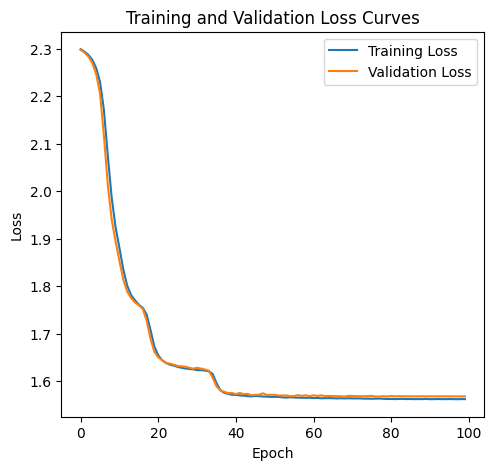

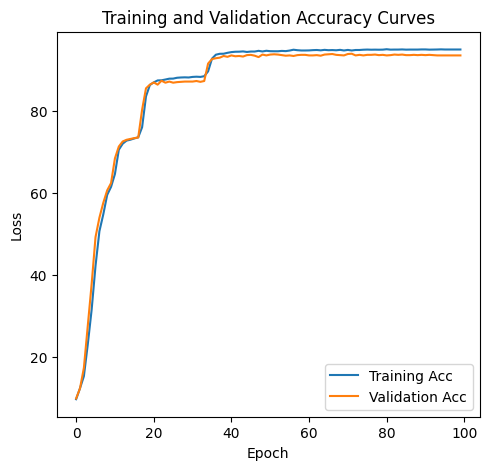

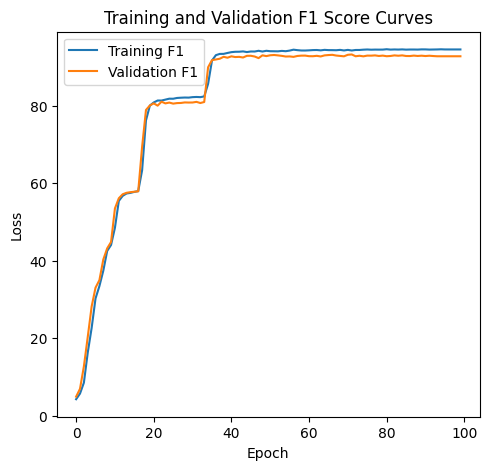

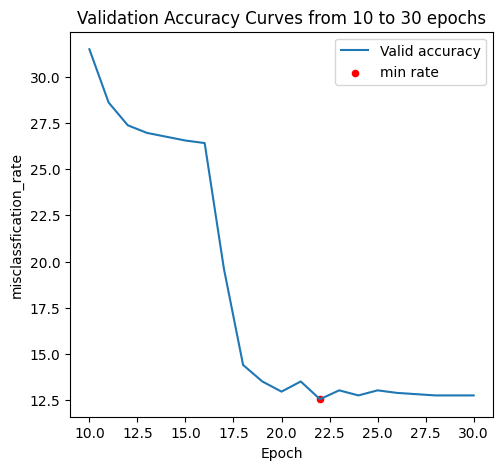

In [130]:
input_dim =  256
hidden_dim = 12
output_dim = 10

model = SimpleNN1(input_dim, hidden_dim, output_dim)

if __name__ == "__main__":
    main(model, "checkpoint_net1.pth", "Net-1.csv")

## 定義 neural network 的架構，net2 -> two hidden layer

In [131]:
class SimpleNN2(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(SimpleNN2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
#         self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
#         out = self.softmax(out)
        return out

此網路架構可以看到，100 epoch，training accuracy為98.01%，valid accuracy為96.16%
與net1相比有明顯提升，此網路架構更能對應x與y之間的關係。
繪製10-30epoch的misclassfication rate，並且標記最低點的值。

SimpleNN2(
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
)
Epoch[1/100], Train Loss: 2.2995, Train Accuracy: 10.46%, Train F1: 4.87% | Valid Loss: 2.2663, Valid Accuracy: 13.58%, Valid F1: 7.30% | LR: 0.000043
Epoch[2/100], Train Loss: 2.2491, Train Accuracy: 15.64%, Train F1: 8.16% | Valid Loss: 2.2098, Valid Accuracy: 19.14%, Valid F1: 9.74% | LR: 0.000051
Epoch[3/100], Train Loss: 2.1905, Train Accuracy: 27.81%, Train F1: 17.74% | Valid Loss: 2.1389, Valid Accuracy: 35.53%, Valid F1: 24.05% | LR: 0.000064
Epoch[4/100], Train Loss: 2.1030, Train Accuracy: 36.98%, Train F1: 26.13% | Valid Loss: 2.0286, Valid Accuracy: 40.05%, Valid F1: 28.45% | LR: 0.000082
Epoch[5/100], Train Loss: 1.9664, Train Accuracy: 42.31%, Train F1: 31.28% | Valid Loss: 1.8523, Valid Accuracy: 50.75%, Valid F1: 39.88% | LR: 0.000104
Epoch[6/100], Train Loss: 1.

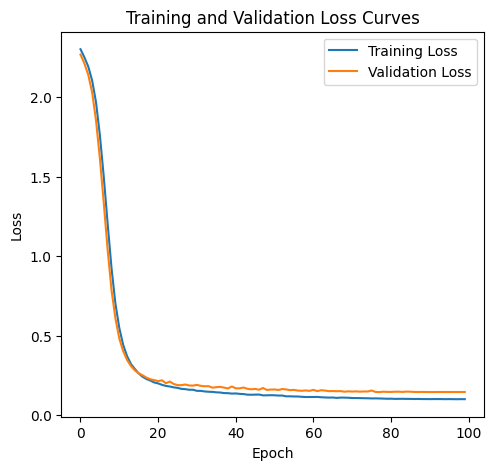

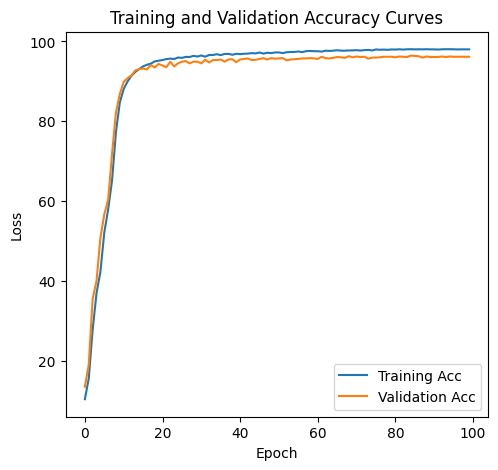

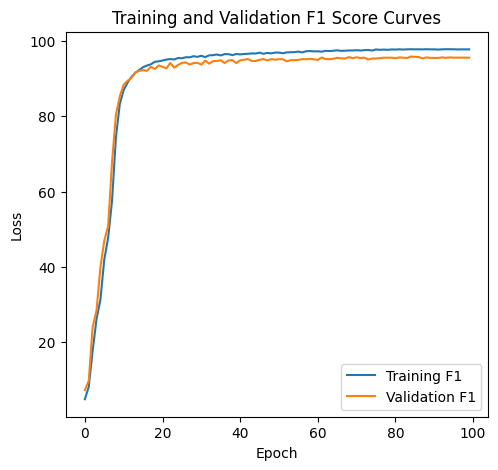

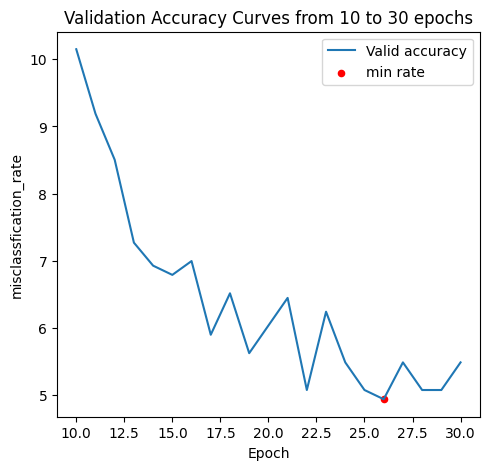

In [132]:
input_dim =  256
hidden_dim1 =  64
hidden_dim2 = 16
output_dim = 10

model = SimpleNN2(input_dim, hidden_dim1, hidden_dim2, output_dim)

if __name__ == "__main__":
    main(model, "checkpoint_net2.pth", "Net-2.csv")

## 定義 neural network 的架構，net3 -> four hidden layer

In [133]:
class SimpleNN3(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4 ,output_dim):
        super(SimpleNN3, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.relu = nn.ReLU()
        self.fc5 = nn.Linear(hidden_dim4, output_dim)
#         self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
#         out = self.softmax(out)
        return out

此網路架構可以看到，100 epoch，training accuracy為99.04%，valid accuracy為96.30%
與net-2相比traning accuracy有再往上提升，但valid accuracy沒有太大的提升，些微的overfitting產生。
繪製10-30epoch的misclassfication rate，並且標記最低點的值。

SimpleNN3(
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=10, bias=True)
)
Epoch[1/100], Train Loss: 2.3193, Train Accuracy: 7.44%, Train F1: 1.39% | Valid Loss: 2.3206, Valid Accuracy: 7.41%, Valid F1: 1.38% | LR: 0.000043
Epoch[2/100], Train Loss: 2.3148, Train Accuracy: 7.44%, Train F1: 1.39% | Valid Loss: 2.3162, Valid Accuracy: 7.41%, Valid F1: 1.38% | LR: 0.000051
Epoch[3/100], Train Loss: 2.3105, Train Accuracy: 7.44%, Train F1: 1.39% | Valid Loss: 2.3113, Valid Accuracy: 7.41%, Valid F1: 1.38% | LR: 0.000064
Epoch[4/100], Train Loss: 2.3042, Train Accuracy: 7.44%, Train F1: 1.39% | Valid Loss: 2.3018, Valid Accuracy: 7.41%, Valid F1: 1.38% | LR: 0.000082
Epoch[5/100], Train Loss: 2.2870, Train Accuracy: 15.62%, Train F1: 9.55%

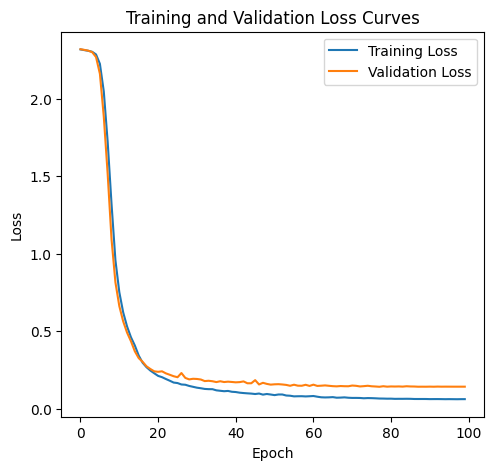

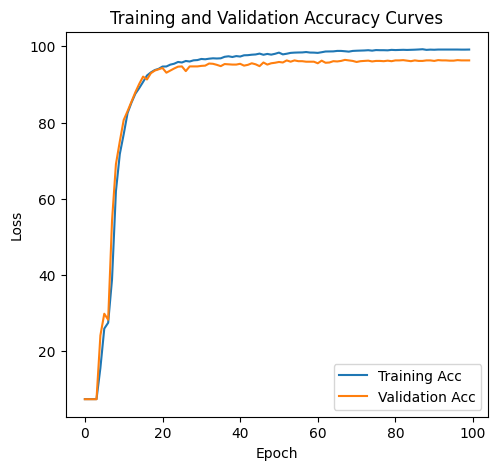

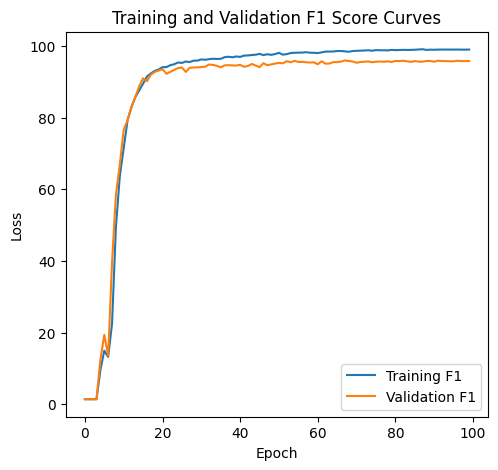

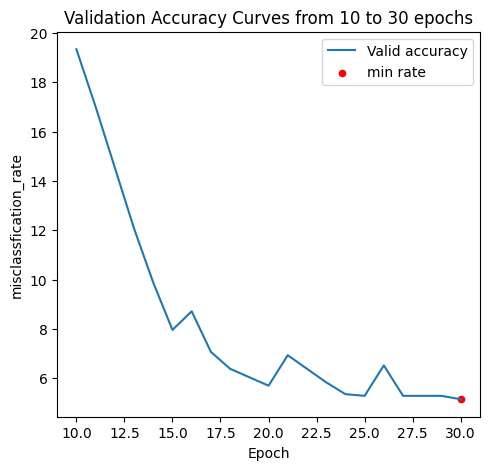

In [134]:
input_dim =  256
hidden_dim1 =  64
hidden_dim2 = 64
hidden_dim3 =  16
hidden_dim4 = 16
output_dim = 10

model = SimpleNN3(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim)

if __name__ == "__main__":
    main(model, "checkpoint_net3.pth", "Net-3.csv")